## QUANTUM AUTOENCODER ##

In [1]:
import time
import pennylane as qml
import matplotlib.pyplot as plt
import numpy as np
import csv
from pennylane import numpy

/Users/edoardozappia/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
np.random.seed(12)

In [3]:
def ansatz(params, n_wires_latent, n_wires_trash):
    init_weights = params[:5]
    init_weights = qml.numpy.tensor(init_weights, requires_grad=True)
    weights = params[5:]
    weights = np.reshape(weights, (2, 4, 2))
    weights = qml.numpy.tensor(weights, requires_grad=True)
    qml.SimplifiedTwoDesign(initial_layer_weights=init_weights, weights=weights, wires=range(n_wires_latent+n_wires_trash))

In [4]:
def swap_test(num_latent, num_trash):
    auxiliary_qubit = num_latent + 2 * num_trash
    qml.Hadamard(auxiliary_qubit)
    for i in range(num_trash):
        qml.CSWAP(wires=[auxiliary_qubit, num_latent + i, num_latent + num_trash + i])
    qml.Hadamard(auxiliary_qubit)

In [5]:
n_wires_latent = 3
n_wires_trash = 2
n_wires_total = n_wires_latent + 2 * n_wires_trash +1

In [6]:
dev = qml.device("default.qubit", wires=n_wires_total)

In [7]:
#def quantum_encoder_train(init_weights, weights, n_wires_latent, n_wires_trash):
#    ansatz(init_weights, weights)
#    swap_test(n_wires_latent, n_wires_trash)

In [8]:
def quantum_encoder_train(params, n_wires_latent, n_wires_trash):
    ansatz(params,n_wires_latent, n_wires_trash)
    swap_test(n_wires_latent, n_wires_trash)
    

In [9]:
@qml.qnode(dev)
def domain_wall(params):
    # Separare i parametri
    #init_weights = params[:5]
    #init_weights = qml.numpy.tensor(init_weights, requires_grad=True)
    #weights = params[5:]
    #weights = np.reshape(weights, (2, 4, 2))
    #weights = qml.numpy.tensor(weights, requires_grad=True)
    qml.X(2)
    qml.X(3)
    qml.X(4)
    quantum_encoder_train(params, n_wires_latent, n_wires_trash)
    # n_wires_latent and n_wires_trash are global variables
    #quantum_encoder_train(init_weights, weights, n_wires_latent, n_wires_trash)
    return qml.probs(wires=7)#, op=qml.PauliZ(7))
    #return qml.expval(qml.Z(7))

In [10]:
initial_point = np.random.random((5,))
#print(np.shape(initial_point))
initial_point = qml.numpy.tensor(initial_point, requires_grad=True)
weights = np.random.random((2, 4, 2))
weights = qml.numpy.tensor(weights, requires_grad=True)
#print(np.shape(weights))
#print(weights)
params = np.concatenate([initial_point, weights.flatten()])
params = qml.numpy.tensor(params, requires_grad=True)
#print(params)
#print(params[:5])

(<Figure size 800x900 with 1 Axes>, <Axes: >)


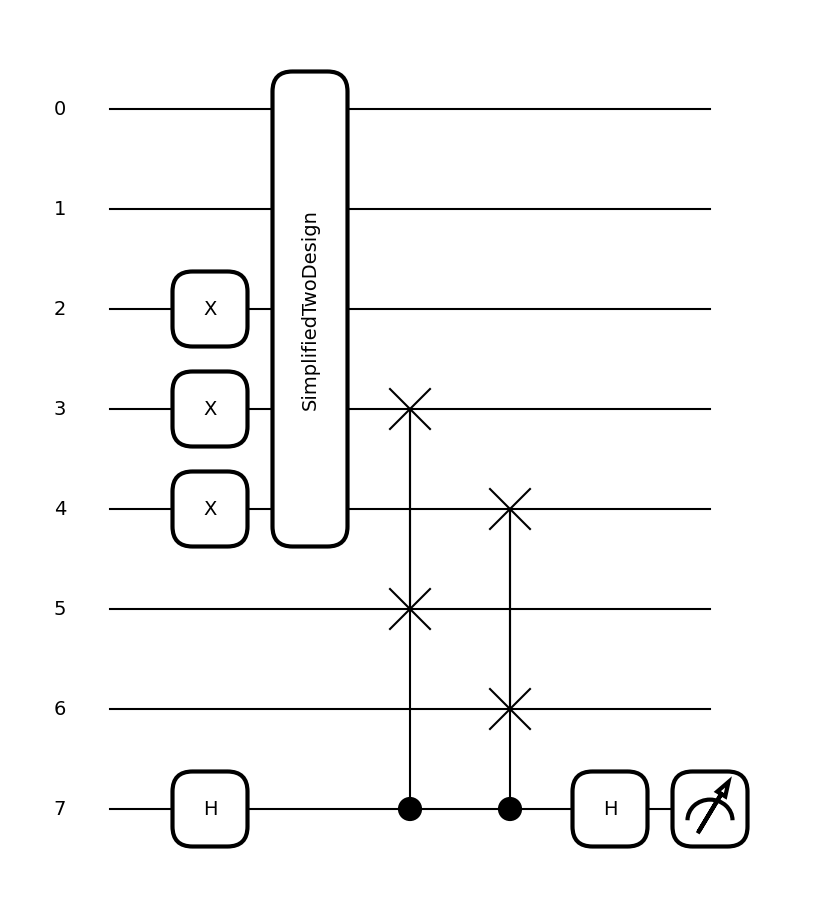

In [11]:
drawer = qml.draw_mpl(domain_wall)
print(drawer(params))

In [12]:
# Definizione della funzione di costo come la somma delle probabilità di misurare 1
def cost_function(params):
    
    # Ottiene le probabilità di misurazione
    probs = domain_wall(params)
    #print(f"Probabilities: {probs}")
    
    # La funzione di costo è la somma delle probabilità di ottenere 1
    cost = probs[1]  # Assumendo che prob[1] rappresenti la probabilità di misurare 1
    #print(f"Probability of measuring 1: {cost}")
    return cost


In [13]:
# Inizializzazione dell'ottimizzatore
opt = qml.GradientDescentOptimizer(stepsize=0.1)
steps = 150
costs = []

# Ciclo di addestramento
start = time.time()
for i in range(steps):
    params, cost_val = opt.step_and_cost(cost_function, params)
    costs.append(cost_val)
    #if i%5==0:
        #print(f"Step {i+1}: cost = {cost_val:.4f}")

elapsed = time.time() - start
print(f"Fit in {elapsed:0.2f} seconds")
# Stampa dei pesi ottimizzati
#print("Pesi ottimizzati:", params)
#opt_weights = params

Fit in 5.96 seconds


In [14]:
opt_weights = params
print(opt_weights)

[ 0.44553756  0.87973987 -0.04354292  1.67195606  0.48797144  0.03396417
  0.30141413  0.00525582 -0.21654872  0.37283446  0.49846461  1.46327069
  1.15204293  0.91253883  0.18987634  0.14797388  0.37597797  0.68432507
  0.95772873  0.47291973  1.76135989]


In [15]:
# Salva i pesi ottimizzati in un file CSV
with open("optimized_weights.csv", mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Peso"])
    writer.writerows([[weight] for weight in weights])


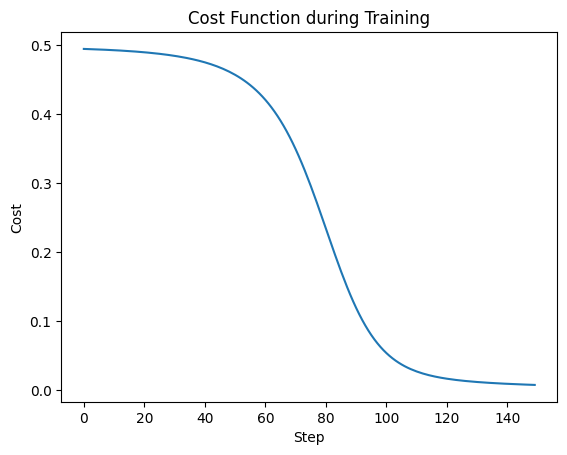

In [16]:
# Traccia la funzione di perdita durante l'addestramento
plt.plot(costs)
plt.xlabel('Step')
plt.ylabel('Cost')
plt.title('Cost Function during Training')
plt.show()

In [17]:
dev_autoencoder = qml.device("default.qubit", wires=n_wires_latent+n_wires_trash)

In [18]:
def reset_to_zero(wir):
    m = qml.measure(wir[0])
    m = qml.measure(wir[1])
    qml.cond(m, qml.PauliX)(wir[0])
    qml.cond(m, qml.PauliX)(wir[1])

In [19]:
@qml.qnode(dev_autoencoder)
def autoencoder(opt_weights):
    qml.X(2)
    qml.X(3)
    qml.X(4)
    ansatz(opt_weights, n_wires_latent, n_wires_trash) 
    #domain_wall(opt_weights)
    wir=[3, 4]
    reset_to_zero(wir)
    qml.adjoint(ansatz)(opt_weights, n_wires_latent, n_wires_trash)
    #return qml.state()
    return [qml.expval(qml.PauliZ(i)) for i in range(5)]


(<Figure size 900x675 with 1 Axes>, <Axes: >)


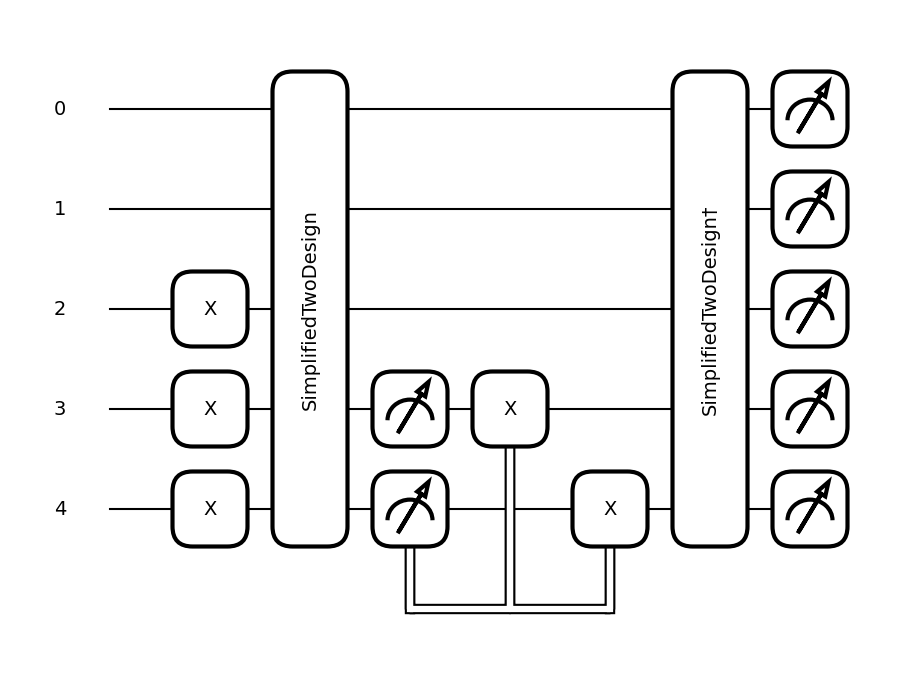

In [20]:
drawer_1 = qml.draw_mpl(autoencoder)
print(drawer_1(opt_weights))

In [21]:
dev_initial = qml.device("default.qubit", wires=5)
@qml.qnode(dev_initial)
def initial_state():
    qml.X(2)
    qml.X(3)
    qml.X(4)
    return [qml.expval(qml.PauliZ(i)) for i in range(5)]
    
test_state = autoencoder(opt_weights)

In [37]:
def fidelity(initial_state, test_state):    
    for i in range(5):
        f = np.sum((initial_state[i] - test_state[i])**2)
    return 1 - f

In [38]:
fidelity = fidelity(initial_state(), test_state)
print(fidelity)

0.9984588211267496


# DIGIT DATASET #

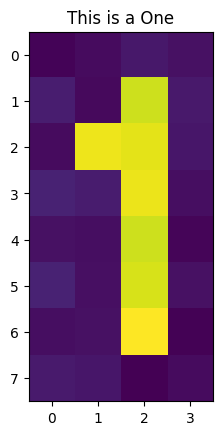

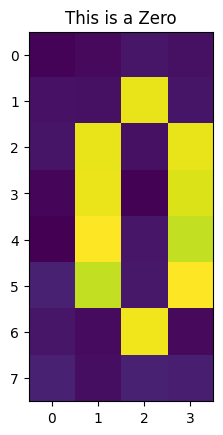

In [24]:
def zero_idx(j, i):
    # Index for zero pixels
    return [
        [i, j],
        [i - 1, j - 1],
        [i - 1, j + 1],
        [i - 2, j - 1],
        [i - 2, j + 1],
        [i - 3, j - 1],
        [i - 3, j + 1],
        [i - 4, j - 1],
        [i - 4, j + 1],
        [i - 5, j],
    ]


def one_idx(i, j):
    # Index for one pixels
    return [[i, j - 1], [i, j - 2], [i, j - 3], [i, j - 4], [i, j - 5], [i - 1, j - 4], [i, j]]


def get_dataset_digits(num, draw=True):
    # Create Dataset containing zero and one
    train_images = []
    train_labels = []
    for i in range(int(num / 2)):
        # First we introduce background noise
        empty = np.array([np.random.uniform(0, 0.1) for i in range(32)]).reshape(8, 4)


        # Now we insert the pixels for the one
        for i, j in one_idx(2, 6):
            empty[j][i] = np.random.uniform(0.9, 1)
        train_images.append(empty)
        train_labels.append(1)
        if draw:
            plt.title("This is a One")
            plt.imshow(train_images[-1])
            plt.show()

    for i in range(int(num / 2)):
        empty = np.array([np.random.uniform(0, 0.1) for i in range(32)]).reshape(8, 4)

        # Now we insert the pixels for the zero
        for k, j in zero_idx(2, 6):
            empty[k][j] = np.random.uniform(0.9, 1)

        train_images.append(empty)
        train_labels.append(0)
        if draw:
            plt.imshow(train_images[-1])
            plt.title("This is a Zero")
            plt.show()

    train_images = np.array(train_images)
    train_images = train_images.reshape(len(train_images), 32)

    for i in range(len(train_images)):
        sum_sq = np.sum(train_images[i] ** 2)
        train_images[i] = train_images[i] / np.sqrt(sum_sq)

    return train_images, train_labels


train_images, __ = get_dataset_digits(2)

In [25]:
initial_point_digits = np.random.random((5,))
initial_point = np.random.random((5,))
#print(np.shape(initial_point))
initial_point = qml.numpy.tensor(initial_point, requires_grad=True)
initial_point_digits = qml.numpy.tensor(initial_point_digits, requires_grad=True)

weights = np.random.random((2, 4, 2))
weights = qml.numpy.tensor(weights, requires_grad=True)
weights_digits = np.random.random((2, 4, 2))
weights_digits = qml.numpy.tensor(weights_digits, requires_grad=True)
#print(np.shape(weights))
#print(weights)
params_digits = np.concatenate([initial_point, initial_point_digits, weights.flatten(), weights_digits.flatten()])
params_digits = qml.numpy.tensor(params_digits, requires_grad=True)
#print(params)
#print(params[:5])

In [26]:
def ansatz_enc(params, n_wires_latent, n_wires_trash):
    init_weights = params[:5]
    init_weights = qml.numpy.tensor(init_weights, requires_grad=True)
    weights = params[26:]
    weights = np.reshape(weights, (2, 4, 2))
    weights = qml.numpy.tensor(weights, requires_grad=True)
    qml.SimplifiedTwoDesign(initial_layer_weights=init_weights, weights=weights, wires=range(n_wires_latent+n_wires_trash))

In [27]:
def ansatz_digits(params, n_wires_latent, n_wires_trash):
    init_weights = params[5:10]
    init_weights = qml.numpy.tensor(init_weights, requires_grad=True)
    weights = params[10:26]
    weights = np.reshape(weights, (2, 4, 2))
    weights = qml.numpy.tensor(weights, requires_grad=True)
    qml.SimplifiedTwoDesign(initial_layer_weights=init_weights, weights=weights, wires=range(n_wires_latent+n_wires_trash))

In [28]:
dev = qml.device("default.qubit", wires=n_wires_total)
@qml.qnode(dev)
def digits_autoencoder(params):
    ansatz_enc(params, n_wires_latent, n_wires_trash)
    ansatz_digits(params, n_wires_latent, n_wires_trash)
    swap_test(n_wires_latent, n_wires_trash)
    return qml.probs(wires=7)


(<Figure size 800x900 with 1 Axes>, <Axes: >)


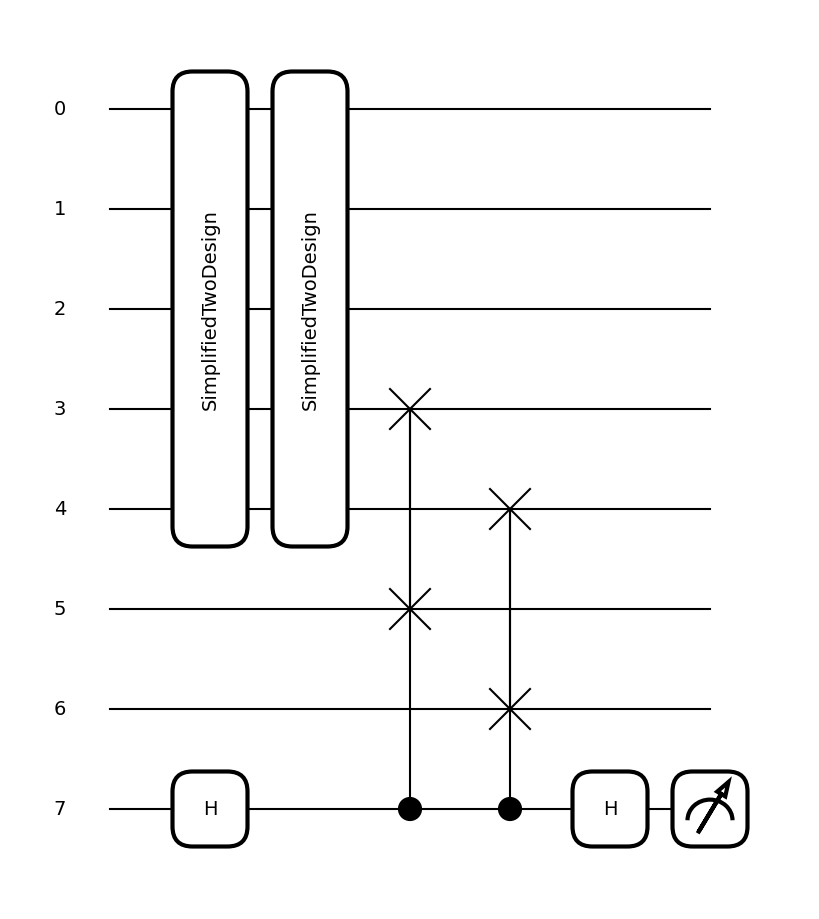

In [29]:
drawer_2 = qml.draw_mpl(digits_autoencoder)
print(drawer_2(params_digits))

In [30]:
# Definizione della funzione di costo come la somma delle probabilità di misurare 1
def cost_function_digits(params):
    
    # Ottiene le probabilità di misurazione
    probs = digits_autoencoder(params)
    #print(f"Probabilities: {probs}")
    
    # La funzione di costo è la somma delle probabilità di ottenere 1
    cost = probs[1]  # Assumendo che prob[1] rappresenti la probabilità di misurare 1
    #print(f"Probability of measuring 1: {cost}")
    return cost

In [31]:
# Inizializzazione dell'ottimizzatore
opt = qml.GradientDescentOptimizer(stepsize=0.1)
steps = 150
costs_digits = []

# Ciclo di addestramento
start = time.time()
for i in range(steps):
    params_digits, cost_val = opt.step_and_cost(cost_function_digits, params_digits)
    costs_digits.append(cost_val)
    #if i%5==0:
        #print(f"Step {i+1}: cost = {cost_val:.4f}")

elapsed = time.time() - start
print(f"Fit in {elapsed:0.2f} seconds")
# Stampa dei pesi ottimizzati
#print("Pesi ottimizzati:", params)
#opt_weights = params

Fit in 12.30 seconds


In [32]:
opt_weights_digits = params_digits
print(opt_weights_digits)

[ 0.21661596  0.33918898  0.17212438  1.01527122  0.3782827   0.31377691
  0.06287607  0.72857847  1.15053817  0.1965962   0.41901483  0.64045629
  0.19710582  0.07178484  0.77847343 -0.03367122  0.10546227  0.24904393
  0.78684447  0.25380819  0.10948542  1.15549116  0.12638728  0.60500539
  0.51993829  0.42191633  0.66558113  0.03068858  0.10458712  0.4220262
  0.11864458 -0.20588166  0.15765527  0.72224016  0.08613143  0.25238105
  0.83805933  1.01096008  0.90578639  0.0977425   0.55591202  0.24370181]


In [33]:
# Salva i pesi ottimizzati in un file CSV
with open("optimized_weights_digits.csv", mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Peso"])
    writer.writerows([[weight] for weight in weights])

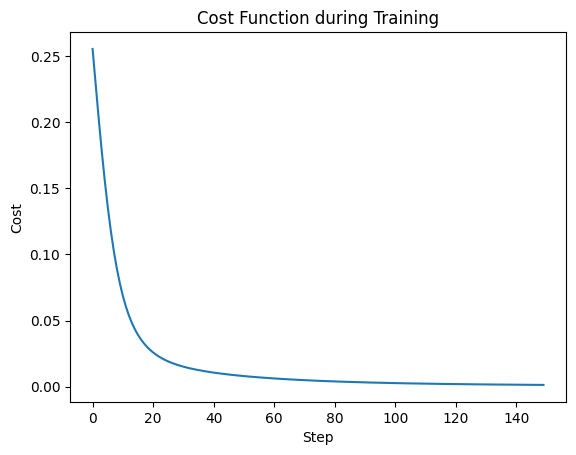

In [34]:
# Traccia la funzione di perdita durante l'addestramento
plt.plot(costs_digits)
plt.xlabel('Step')
plt.ylabel('Cost')
plt.title('Cost Function during Training')
plt.show()

In [35]:
dev_autoencoder = qml.device("default.qubit", wires=n_wires_latent+n_wires_trash)
@qml.qnode(dev_autoencoder)
def autoencoder_digits(opt_weights):
    ansatz_enc(opt_weights, n_wires_latent, n_wires_trash)
    ansatz_digits(opt_weights, n_wires_latent, n_wires_trash) 
    wir=[3, 4]
    reset_to_zero(wir)
    qml.adjoint(ansatz_digits)(opt_weights, n_wires_latent, n_wires_trash)
    #return qml.state()
    return [qml.expval(qml.PauliZ(i)) for i in range(5)]

(<Figure size 900x675 with 1 Axes>, <Axes: >)


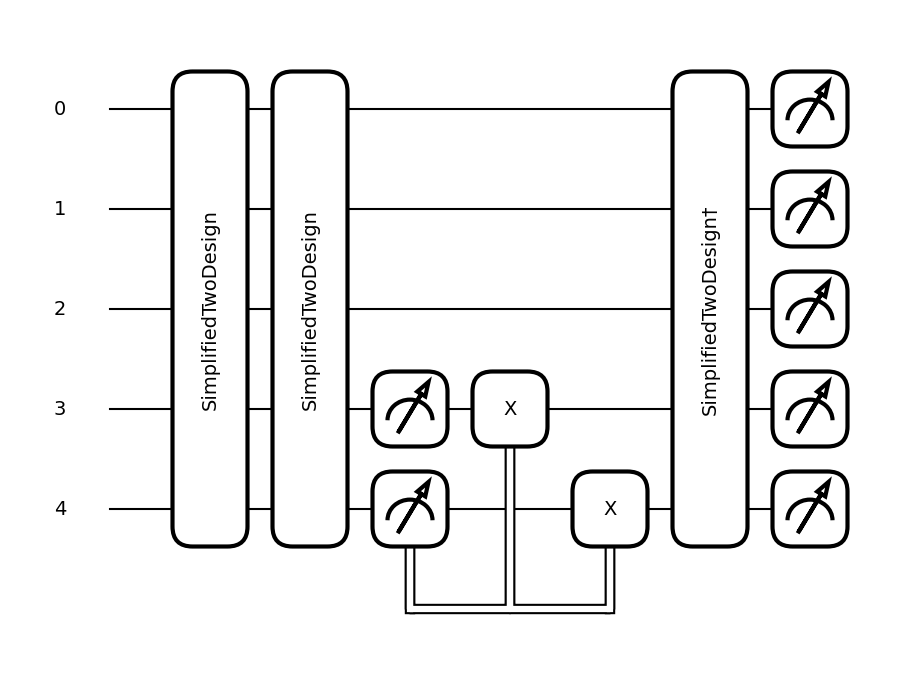

In [36]:
drawer_3 = qml.draw_mpl(autoencoder_digits)
print(drawer_3(opt_weights_digits))

In [39]:
autoencoder_digits(opt_weights_digits)

[tensor(0.58037692, requires_grad=True),
 tensor(0.21576784, requires_grad=True),
 tensor(0.49263326, requires_grad=True),
 tensor(-0.74883746, requires_grad=True),
 tensor(0.75579946, requires_grad=True)]